In [1]:
import numpy as np
import time

In [2]:
# Imports from Qiskit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

### Connect to IBM and create a simulator of chosen Qprocessor

In [3]:
service = QiskitRuntimeService(channel="ibm_quantum",
                    token = "")#Insert your private IBM API token here 

#service = QiskitRuntimeService()
real_backend = service.backend("ibm_sherbrooke")
simulator = AerSimulator.from_backend(real_backend)

## Creating fake backend by modifying errors in chosen IBM Qprocessor 

In [4]:
def get_modified_backend(backend,
                         decrease_measurement_error_factor = 1,
                         decrease_1q_gate_error_factor = 1,
                         decrease_2q_gate_error_factor = 1,
                         decrease_decoherence_factor = 1):

    modified_backend = FakeSherbrooke()
    
    for i in range(127):
        modified_backend.target['measure'][(i,)].error = backend.target['measure'][(i,)].error * decrease_measurement_error_factor
        modified_backend.target['measure'][(i,)].duration = backend.target['measure'][(i,)].duration
        
        modified_backend.target['x'][(i,)].error = backend.target['x'][(i,)].error  * decrease_1q_gate_error_factor
        modified_backend.target['sx'][(i,)].error = backend.target['sx'][(i,)].error * decrease_1q_gate_error_factor
        modified_backend.target['rz'][(i,)].error = backend.target['rz'][(i,)].error * decrease_1q_gate_error_factor
        
        modified_backend.target.qubit_properties[i].t1 = backend.target.qubit_properties[i].t1 / decrease_decoherence_factor
        modified_backend.target.qubit_properties[i].t2 = backend.target.qubit_properties[i].t1 / decrease_decoherence_factor   
    
    for pair in modified_backend.target['ecr'].keys():
        try:
            modified_backend.target['ecr'][pair].error = backend.target['ecr'][pair].error * decrease_2q_gate_error_factor
        except:
            new_pair = (pair[1],pair[0])
            modified_backend.target['ecr'][pair].error = backend.target['ecr'][new_pair].error * decrease_2q_gate_error_factor

    return modified_backend

In [5]:
modified_backend = get_modified_backend(real_backend,0.5,0.5,0.5,0.5)
simulator_mod = AerSimulator.from_backend(modified_backend)
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator_mod, layout_method='trivial')

# For calculation on real IBM Sherbrooke quantum computer
#pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3,layout_method='trivial')

## Methods to generate QV cuircuits

In [6]:
from generate_QV_circuits import get_standard_QV_circuit, get_parity_QV_circuit, get_double_parity_QV_circuit

C:\Files\doktorat\quantum_volume\phyton\qiskit_IBM\QV_calculation\generate_QV_circuits.py:8: SyntaxWarning: invalid escape sequence '\s'
  """Draw parameters of random 2-qubit interaction gate:


## Quantum Volume Cuircuit Parameters

In [7]:
N = 8 #number of qubits
T_tab = [2,4,6,8,10,12,16] #table for number of layers
test_num = 50 #number of tested quantum circuits with for given dimentions
shots_num = 200 #number of runs of each quantum circuit

## Quantum computation

In [8]:
circuit_standard_perfect_tab = []
circuit_standard_tab = []
circuit_parity_tab = []
circuit_double_parity_tab = []
odds_tab = []

for T in T_tab:
    print("T =",T)
    circuits_st_perfect = []
    circuits_st = []
    circuits_p = []
    circuits_pp = []
    odds_t = []
    
    for i in range(test_num):
        
        qc_st_perfect, qc_st_test =  get_standard_QV_circuit(N,T)
        circuits_st_perfect.append(qc_st_perfect)
        circuits_st.append(pass_manager.run(qc_st_test))
        
        circuits_p.append(pass_manager.run(get_parity_QV_circuit(N,T)))

        circuit, odds = get_double_parity_QV_circuit(N,T)
        circuits_pp.append(pass_manager.run(circuit))
        odds_t.append(odds)

    circuit_standard_perfect_tab.append(circuits_st_perfect)
    circuit_standard_tab.append(circuits_st)
    circuit_parity_tab.append(circuits_p)
    circuit_double_parity_tab.append(circuits_pp)
    odds_tab.append(odds_t)

T = 2
T = 4
T = 6
T = 8
T = 10
T = 12
T = 16


In [9]:
perfect_output_states_standard_QV = []

print("perfect simualtion")
for a in range(len(T_tab)):
    print("T = ", T_tab[a])

    vectors = []
    for qc in circuit_standard_perfect_tab[a]:
        v = np.array(Statevector.from_instruction(qc))
        vectors.append(v/np.linalg.norm(v))
    perfect_output_states_standard_QV.append(vectors)

perfect simualtion
T =  2
T =  4
T =  6
T =  8
T =  10
T =  12
T =  16


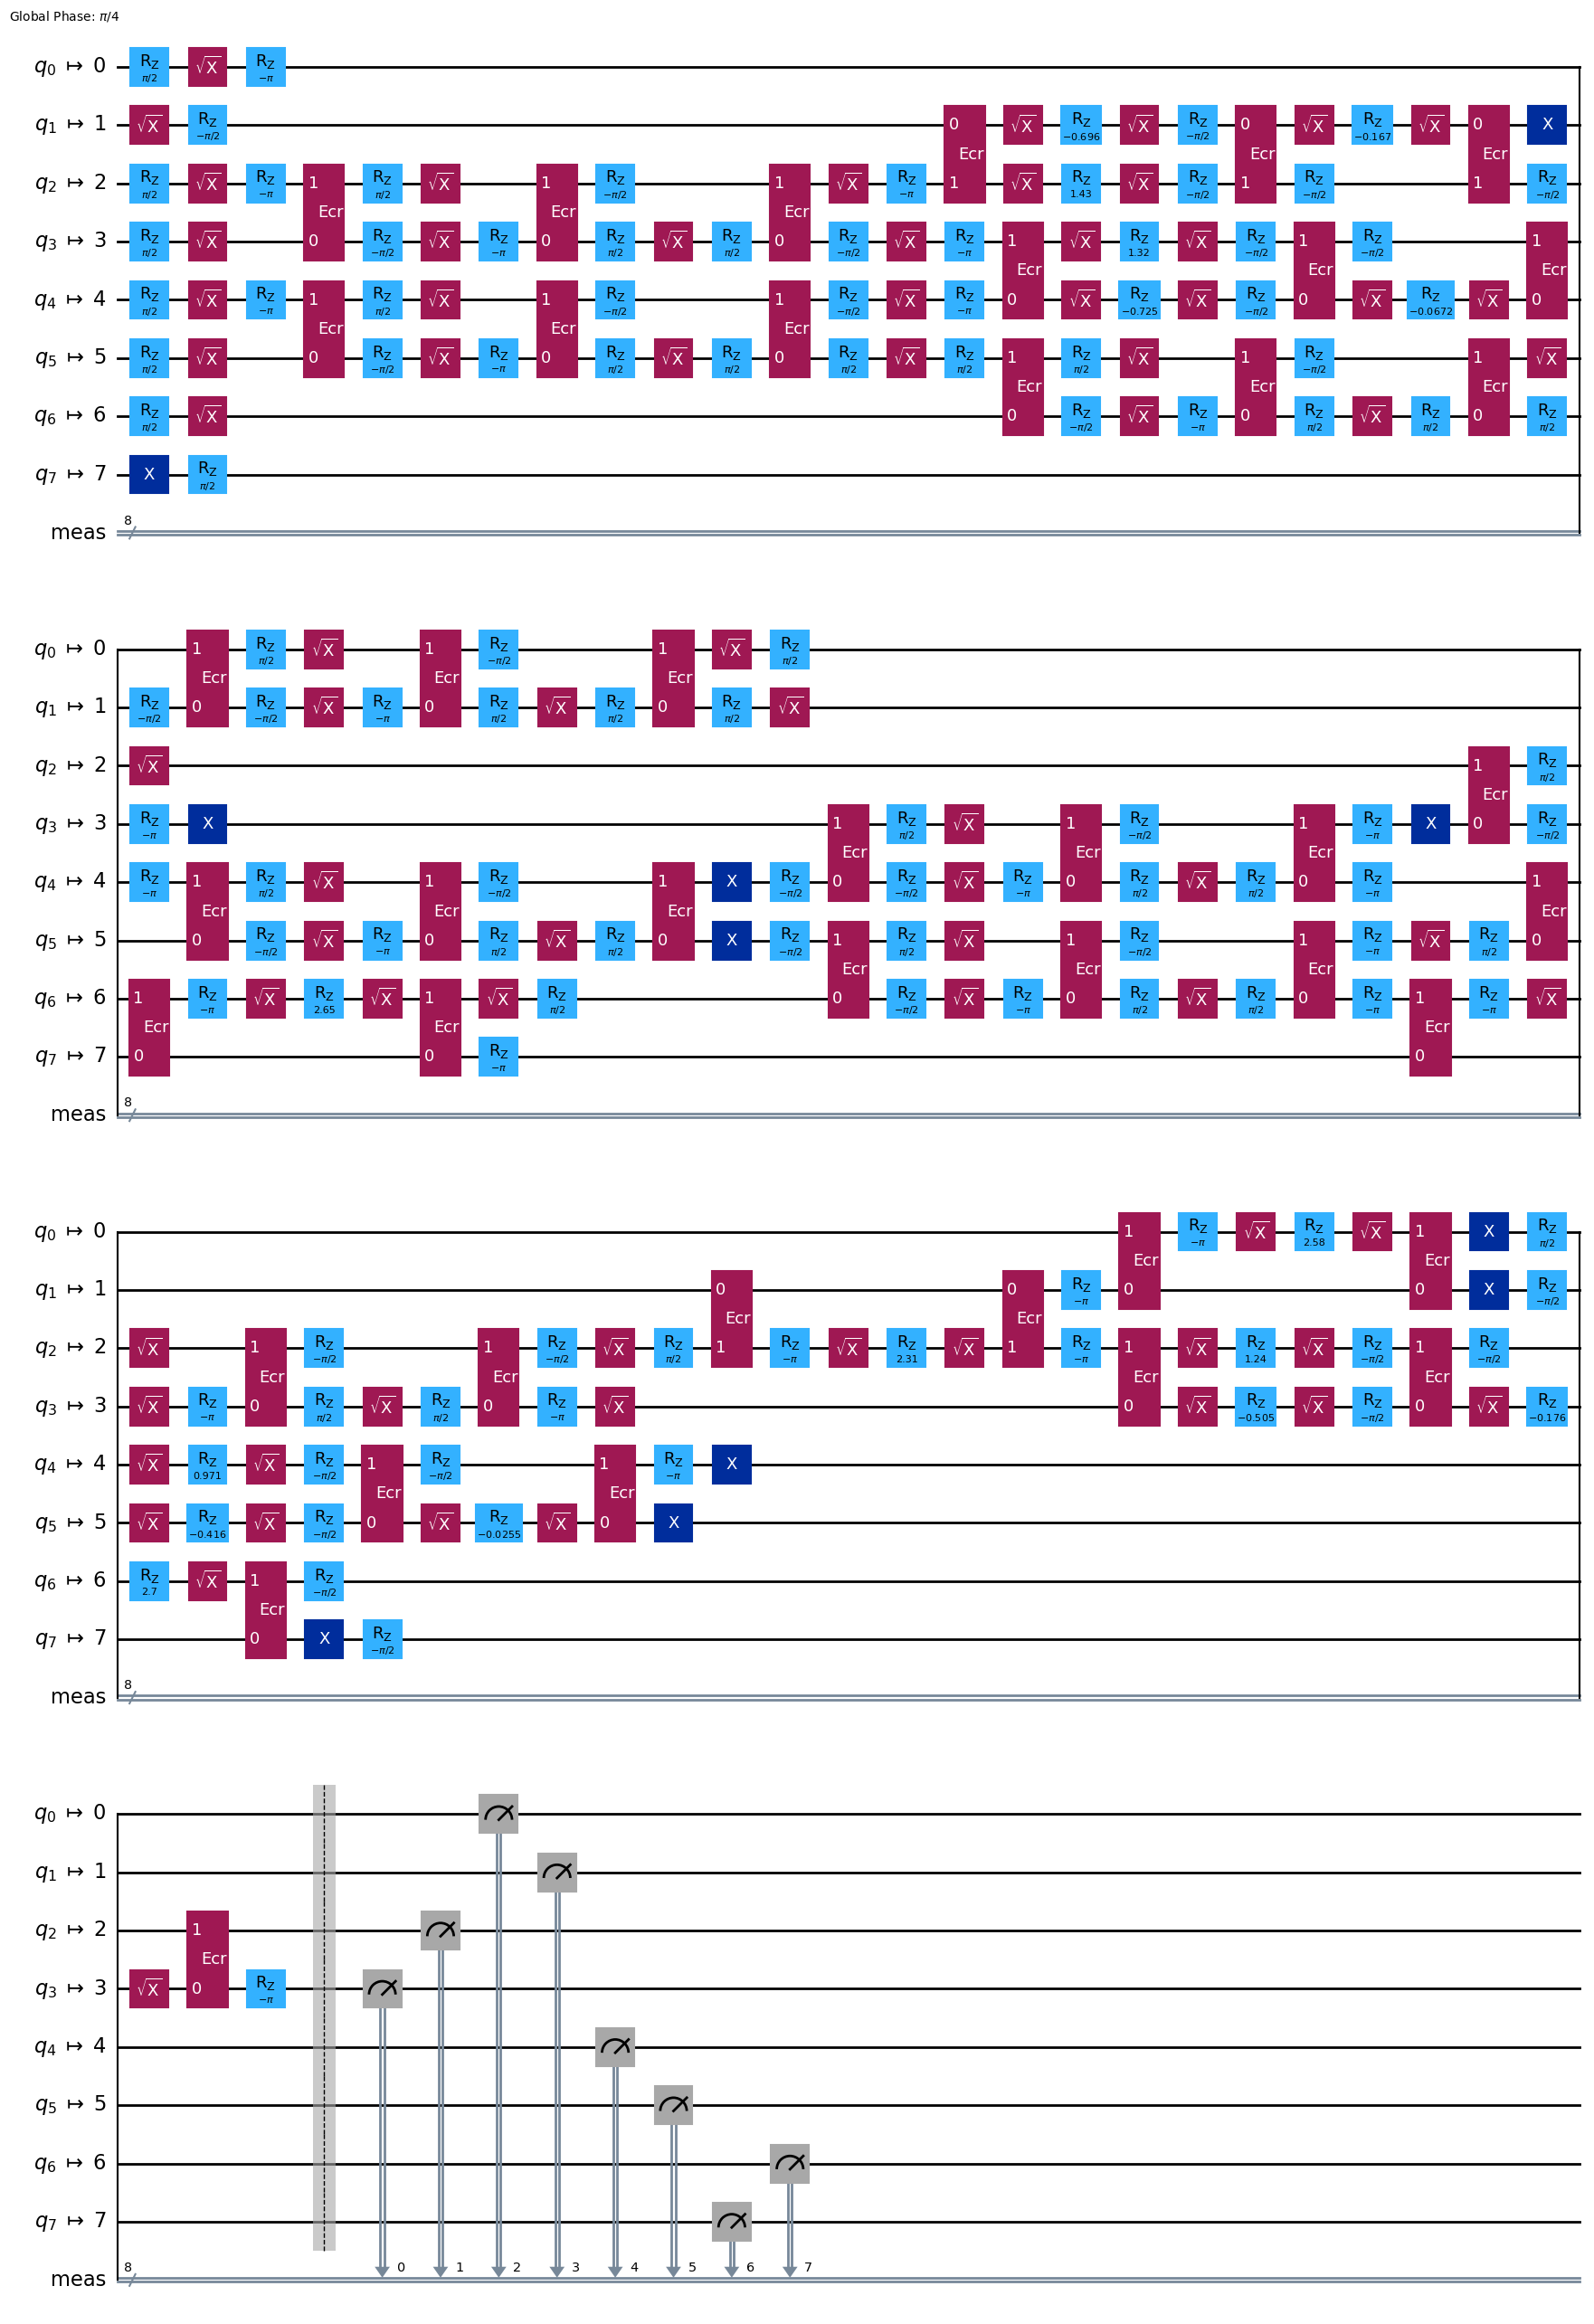

In [10]:
circuit_double_parity_tab[0][0].draw(output="mpl", idle_wires=False, style="iqp")

In [12]:
sampler = Sampler(simulator_mod)
# For calculation on real IBM Sherbrooke quantum computer
#sampler = Sampler(real_backend)

sampler.options.default_shots = shots_num

distribution_standard_tab = []
distribution_parity_tab = []
distribution_double_parity_tab = []

for a, T in enumerate(T_tab):
    print("T = ", T)

    #combine all circits of the same dimentions in one job to speed up the calculations ic case of accual IBM quantum computer
    joint_sample = circuit_standard_tab[a] + circuit_parity_tab[a] + circuit_double_parity_tab[a]
    
    start_time = time.time()
    job = sampler.run(joint_sample) #to run the job 
    results = job.result() 
    print("calculation time = ",time.time() - start_time)

    dist_st = []
    for i in range(test_num):
        dist_st.append(results[i].data.meas.get_counts())
    distribution_standard_tab.append(dist_st)

    dist_p = []
    for i in range(test_num, 2*test_num):
        dist_p.append(results[i].data.meas.get_counts())
    distribution_parity_tab.append(dist_p)

    dist_pp = []
    for i in range(2*test_num,3*test_num): 
        dist_pp.append(results[i].data.meas.get_counts())
    distribution_double_parity_tab.append(dist_pp)

T =  2
calculation time =  4.7664244174957275
T =  4
calculation time =  3.3003005981445312
T =  6
calculation time =  3.625459671020508
T =  8
calculation time =  4.040170431137085
T =  10
calculation time =  4.584594964981079
T =  12
calculation time =  5.353531360626221
T =  16
calculation time =  5.606082201004028


## Posprocessing

In [13]:
from calculate_heavy_outputs import get_hu_standard_perfect_circuit, get_hu_standard_circuit, get_hu_parity_circuit, get_hu_double_parity_circuit

In [14]:
hu_standard_perfect_tab = np.zeros((len(T_tab),test_num))
hu_standard_tab = np.zeros((len(T_tab),test_num))
hu_parity_tab = np.zeros((len(T_tab),test_num))
hu_double_parity_tab = np.zeros((len(T_tab),test_num))

for a, _ in enumerate(T_tab):
    for i in range(test_num):
        hu_standard_perfect_tab[a,i] = get_hu_standard_perfect_circuit(perfect_output_states_standard_QV[a][i],N)
        hu_standard_tab[a,i] = get_hu_standard_circuit(distribution_standard_tab[a][i],perfect_output_states_standard_QV[a][i],N)
        hu_parity_tab[a,i] = get_hu_parity_circuit(distribution_parity_tab[a][i])
        hu_double_parity_tab[a,i] = get_hu_double_parity_circuit(distribution_double_parity_tab[a][i],odds_tab[a][i],N)

In [28]:
for a in range(len(T_tab)):
    np.save(f"results/sym_hu_standard_perfect_tab_{N}{T_tab[a]}",hu_standard_perfect_tab[a])
    np.save(f"results/sym_hu_standard_tab_{N}{T_tab[a]}",hu_standard_tab[a])
    np.save(f"results/sym_hu_parity_tab_{N}{T_tab[a]}",hu_parity_tab[a])
    np.save(f"results/sym_hu_double_parity_tab_{N}{T_tab[a]}",hu_double_parity_tab[a])

# Results
### Loading calculations resoults
Note that this is a very small examplar sample

In [4]:
all_hu_tab = []

N_tab = np.array([6,8])
T_ttab = [np.array([2,4,6,8,10,12,16,20]),
          np.array([2,4,6,8,10,12,16])]

for a in range(len(N_tab)):
    hu_standard_perfect_tab = []
    hu_sandard_tab = []
    hu_parity_tab = []
    hu_double_parity_tab = []
    for b in range(len(T_ttab[a])):
        hu_standard_perfect_tab.append(np.load(f"results/sym_hu_standard_perfect_tab_{N_tab[a]}{T_ttab[a][b]}.npy")) 
        hu_sandard_tab.append(np.load(f"results/sym_hu_standard_tab_{N_tab[a]}{T_ttab[a][b]}.npy")) 
        hu_parity_tab.append(np.load(f"results/sym_hu_parity_tab_{N_tab[a]}{T_ttab[a][b]}.npy")) 
        hu_double_parity_tab.append(np.load(f"results/sym_hu_double_parity_tab_{N_tab[a]}{T_ttab[a][b]}.npy")) 

    all_hu_tab.append([hu_standard_perfect_tab,hu_sandard_tab,hu_parity_tab,hu_double_parity_tab])

## Examplar plots

In [5]:
from plot_heavy_outputs import show_heavy_outputs

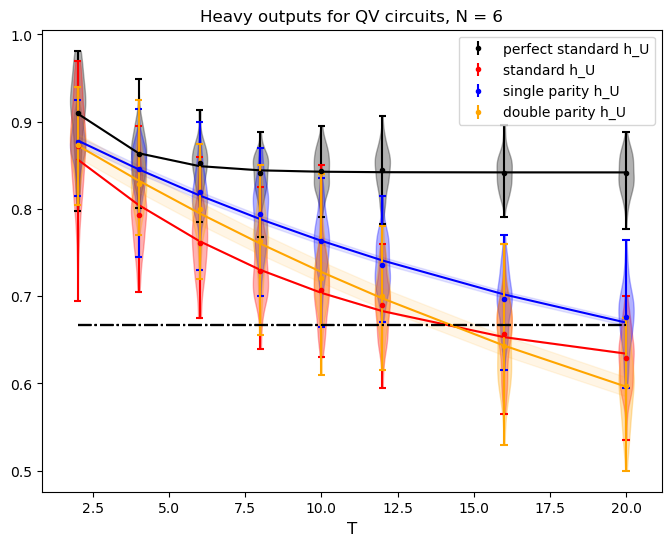

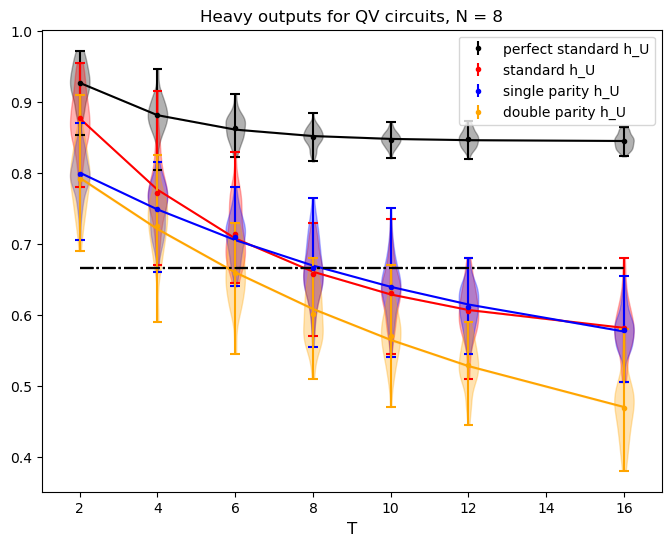

In [6]:
for i in range(2):
    show_heavy_outputs(all_hu_tab[i],T_ttab[i],N_tab[i])